In [15]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp
from scipy.integrate import odeint


## Transfer Function

A simple one pole RC filter has the following transfer function

$$
G(s) = \frac{1}{1+\tau\cdot{s}}
$$

And the following differential equation

$$
V_{out}(t) = V_{in}(t)-RC \frac{dV_{out}}{dt}
$$

In [16]:
# Constants and functions
hz2rad = lambda f: 2*math.pi*f
rad2hz = lambda omega: omega/(2*math.pi)
fc = hz2rad(100)
tau = 1/fc# Time constant
F = 500#Hz

t = np.linspace(0,1,120100)
dt = t[1]-t[0]
freqs = np.fft.fftfreq(len(t),dt)

def H_RC(omega):
    s = omega*1j
    den = 1 + tau*s
    return 1/den


def H_ChebyshevBand(freq, fc, stageCount):
    C = 0.01*10**(-6) # Faraday
    R1 = 10*10**3 # ohm
    stages = [(0.5359, 0.522), (0.2657, 1.379),
              (0.1848, 1.711), (0.1582, 1.913)] # pairs of (k1,k2)
    
      
    s = 1j * (freq)
    G = 1
    
    for i in range(stageCount):
        stage = stages[i]
        R = stage[0]/(C*fc)
        Rf = R1*stage[1]  
        G *=(4*R*C*(R1+Rf)*s)/(8*(R**2)*(C**2)*(s**2)*(R1-Rf)+2*R*C*(3*R1-Rf)*s+R1) # Good band pass FT, not a low pass though
    
    return np.abs(G)


def H_ChebyshevLow(freq, fc, stageCount):
    C = 0.01*10**(-6) # Faraday
    R1 = 10*10**3 # ohm
    stages = [(0.5359, 0.522), (0.2657, 1.379),
              (0.1848, 1.711), (0.1582, 1.913)] # pairs of (k1,k2)
    w = hz2rad(freq)
    if (freq == 0):
        return 0
      
    s = 1j * (w)
    G = 1
    
    for i in range(stageCount):
        stage = stages[i]
        R = stage[0]/(C*fc)
        Rf = R1*stage[1]
        Zc = -1j/(C*w) # impedancia do capacitor
        
        k1 = (2*Zc+R)/(3*R*Zc + R*R + Zc*Zc)
        k2 = (Zc+R)/(3*R*Zc + R*R + Zc*Zc)
        num = 1 - 2*k1*R + R*(1-R*k1)/Zc
        den = R1/(R1+Rf) - 2*R*k2 + R*(1-R*k2)/Zc
        G *= num/den # Good band pass FT, not a low pass though
    
    return G

def Phase(H_w):
    
    return math.atan(np.imag(H_w)/np.real(H_w))

def SawWave(x,f):
    amp = 3
    T = 1/f
    
    dydx = (-2*amp)/T 
    return (x%T)*dydx + amp

def SquareWave(xIn,f):
    amp = 3
    T = 1/f
    if (xIn%T > 0.5*T):
        return amp
    else: 
        return -amp

    
def plotBode(w, H, cutoffFreq, logScale = True):
    fig,axs = plt.subplots(2,1)
    G = np.abs(H)# gain
    vectorizedPhase = np.vectorize(Phase)
    P =  vectorizedPhase(H)# phase
    axs[0].plot(w[:len(freqs)//2],G[:len(freqs)//2])
    axs[0].axvline(x = cutoffFreq, ls = '--', c='black', lw=2)
    axs[0].set_title('Gain plot (cutoff = {:.2f}Hz)'.format(rad2hz(cutoffFreq)))
    axs[0].set_ylabel('$|G(j\omega)|$')
    if (logScale):
        axs[0].set_yscale('log')
        axs[0].set_xscale('log')
    axs[0].set_xlim(0.1, np.max(w))
    axs[0].set_ylim(10**(-5),10-10**(-10))

    axs[1].plot(w[:len(freqs)//2],P[:len(freqs)//2])
    axs[1].axvline(x = cutoffFreq, ls = '--', c='black', lw=2)
    if (logScale):
        axs[1].set_xscale('log')
    axs[1].set_xlim(0.1, np.max(w))


    axs[1].set_title('Phase plot')
    axs[1].set_ylabel('$Phase(\omega)$')
    axs[1].set_xlabel('$\omega$')
    axs[1].grid()
    #axs[1].set_ylim(-0.02,0.02)

    axs[0].grid()
    fig.set_size_inches(12,8)
    return axs, fig


# RC Filter

(array([<AxesSubplot:title={'center':'Gain plot (cutoff = 100.00Hz)'}, ylabel='$|G(j\\omega)|$'>,
        <AxesSubplot:title={'center':'Phase plot'}, xlabel='$\\omega$', ylabel='$Phase(\\omega)$'>],
       dtype=object),
 <Figure size 864x576 with 2 Axes>)

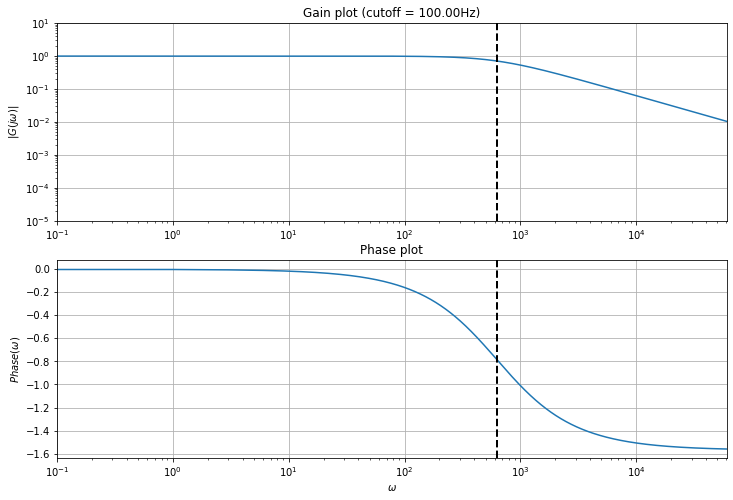

In [17]:
H_w = H_RC(freqs)

################################ plot
H_w
plotBode(freqs,H_w,fc)

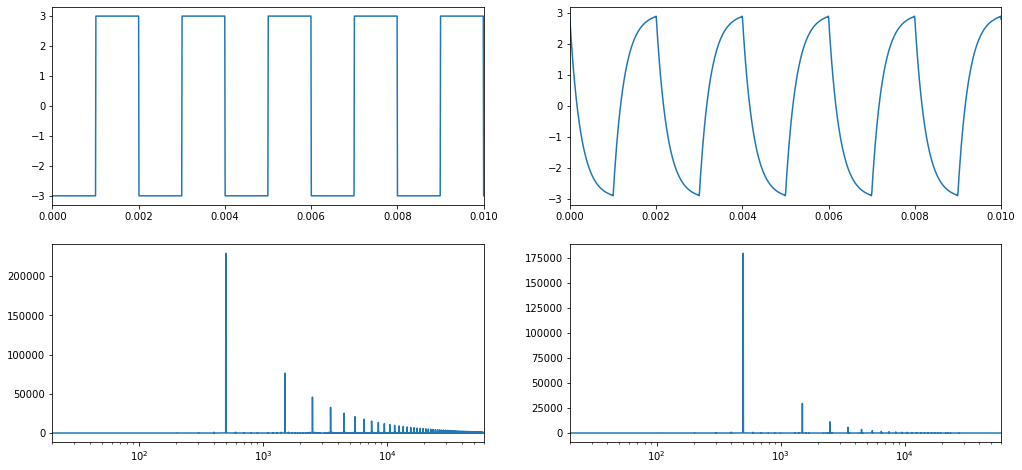

In [18]:
# sinal de entrada


x = [SquareWave(i,F) for i in t]

# exit signal
fft_x = np.fft.fft(x)
fft_y = H_RC(freqs)*fft_x
y_rc = np.real(np.fft.ifft(fft_y))

# applying the fourier transform to the input and output

fig, axs = plt.subplots(2,2)
axs[0,0].plot(t,x)
axs[0,0].set_xlim(0,5/F)

axs[0,1].plot(t,y_rc)
axs[0,1].set_xlim(0,5/F)

axs[1,0].plot(freqs[:len(freqs)//2], np.abs(fft_x[:len(freqs)//2]))
axs[1,1].plot(freqs[:len(freqs)//2], np.abs(fft_y[:len(freqs)//2]))
axs[1,0].set_xscale('log')
axs[1,0].set_xlim(20,np.max(freqs))
axs[1,1].set_xscale('log')
axs[1,1].set_xlim(20,np.max(freqs))

fig.set_size_inches(17,8)


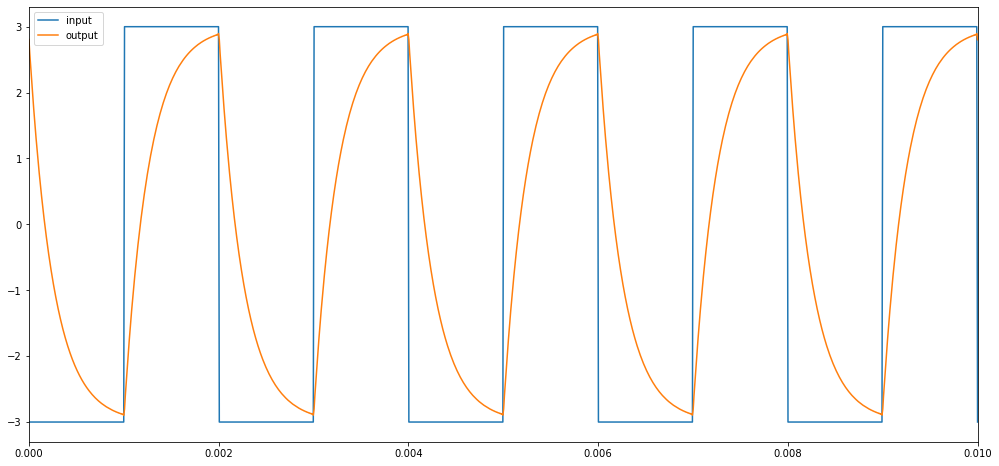

In [19]:
plt.plot(t,x, label = 'input')
plt.plot(t,y_rc, label = 'output')
plt.xlim(0,5/F)
plt.legend()
plt.gcf().set_size_inches(17,8)

# Chebyshev bandpass filter

500
Maximum gain = 0.00
Chebyshev filters by stage number


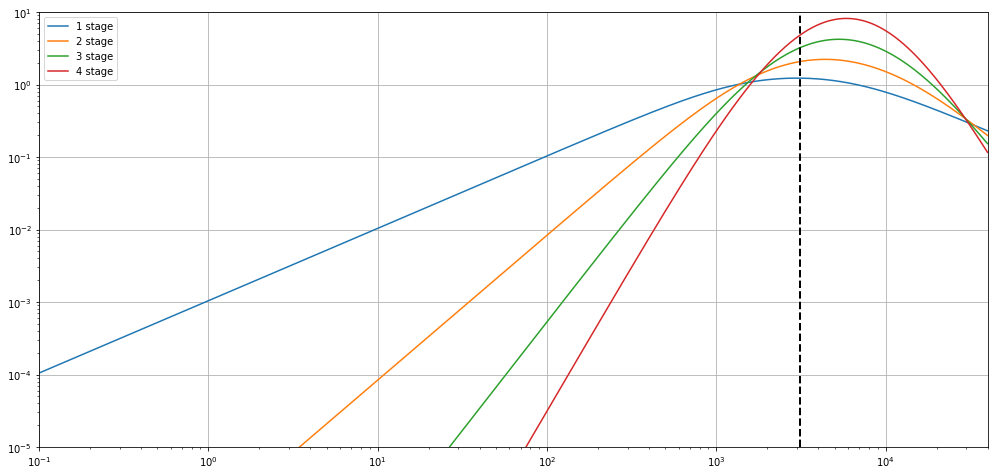

In [20]:
fc = hz2rad(500)
n = 4
print(F)
H_w = H_ChebyshevBand(freqs, fc, n)
# axs, fig = plotBode(freqs[:len(freqs)//2], H_w[:len(freqs)//2], fc)
maxGain = np.abs(H_w[0])
print("Maximum gain = {:.2f}".format(maxGain))
print('Chebyshev filters by stage number')

plt.plot(freqs[:len(freqs)//2], H_ChebyshevBand(freqs, fc, 1)[:len(freqs)//2], label = str(1)+' stage')
plt.plot(freqs[:len(freqs)//2], H_ChebyshevBand(freqs, fc, 2)[:len(freqs)//2], label = str(2)+' stage')
plt.plot(freqs[:len(freqs)//2], H_ChebyshevBand(freqs, fc, 3)[:len(freqs)//2], label = str(3)+' stage')
plt.plot(freqs[:len(freqs)//2], H_ChebyshevBand(freqs, fc, 4)[:len(freqs)//2], label = str(4)+' stage')
plt.axvline(x = fc, ls = '--', c='black', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.1, 40000)
plt.ylim(10**(-5),10-10**(-10))
plt.legend()
plt.grid()
plt.gcf().set_size_inches(17,8)

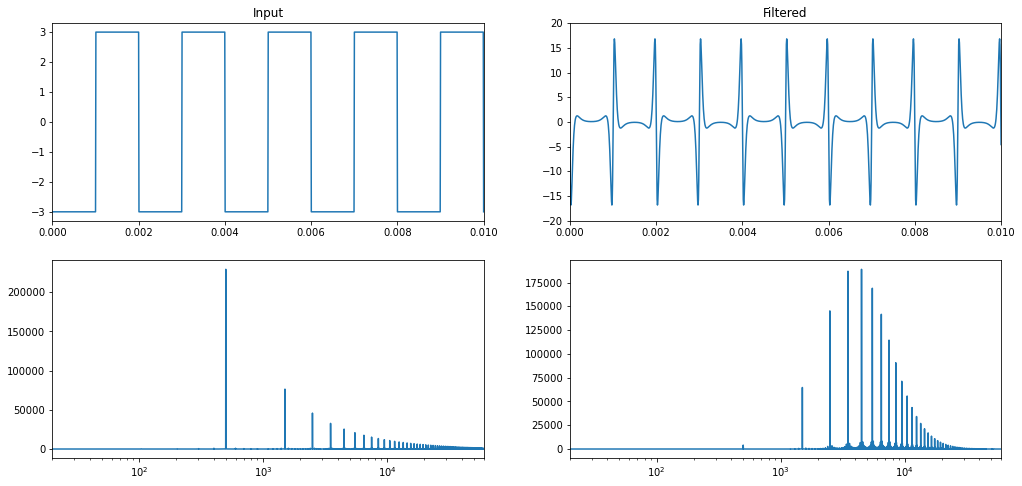

In [21]:

fft_y = H_w*fft_x
y_ch = np.fft.ifft(fft_y)


fig, axs = plt.subplots(2,2)
axs[0,0].plot(t,x)
axs[0,0].set_title("Input")
axs[0,0].set_xlim(0,5/F)

axs[0,1].plot(t,np.real(y_ch))
axs[0,1].set_xlim(0,5/F)
axs[0,1].set_title("Filtered")
axs[0,1].set_ylim(-20,20)

axs[1,0].plot(freqs[:len(freqs)//2], np.abs(fft_x[:len(freqs)//2]))
axs[1,1].plot(freqs[:len(freqs)//2], np.abs(fft_y[:len(freqs)//2]))
axs[1,0].set_xscale('log')
axs[1,0].set_xlim(20,np.max(freqs))
axs[1,1].set_xscale('log')
axs[1,1].set_xlim(20,np.max(freqs))



fig.set_size_inches(17,8)

500


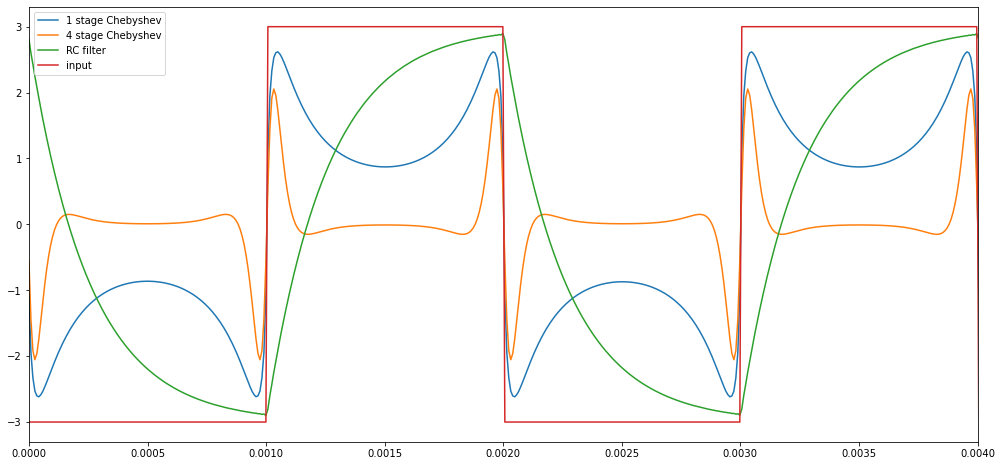

In [22]:
# diferenca entre 1 e 4 estagios
print(F)



H_w1 = H_ChebyshevBand(freqs, fc, 1)
H_w2 = H_ChebyshevBand(freqs, fc, 4)
maxGain1 = np.max(np.abs(H_w1))
maxGain2 = np.max(np.abs(H_w2))

fft_y1 = H_w1*fft_x
fft_y2 = H_w2*fft_x

y1 = np.real(np.fft.ifft(fft_y1))
y2 =  np.real(np.fft.ifft(fft_y2))


plt.plot(t,(1/maxGain1)*y1, label = '1 stage Chebyshev')
plt.plot(t,(1/maxGain2)*y2, label = '4 stage Chebyshev')
plt.plot(t,y_rc, label = 'RC filter')
plt.plot(t,x, label = 'input')
plt.legend(loc = 'upper left')
plt.xlim(0,2/F)
plt.gcf().set_size_inches(17,8)

# Low Pass Chebyshev filter

150.0hz = 942.48rad/s
Chebyshev filters by stage number


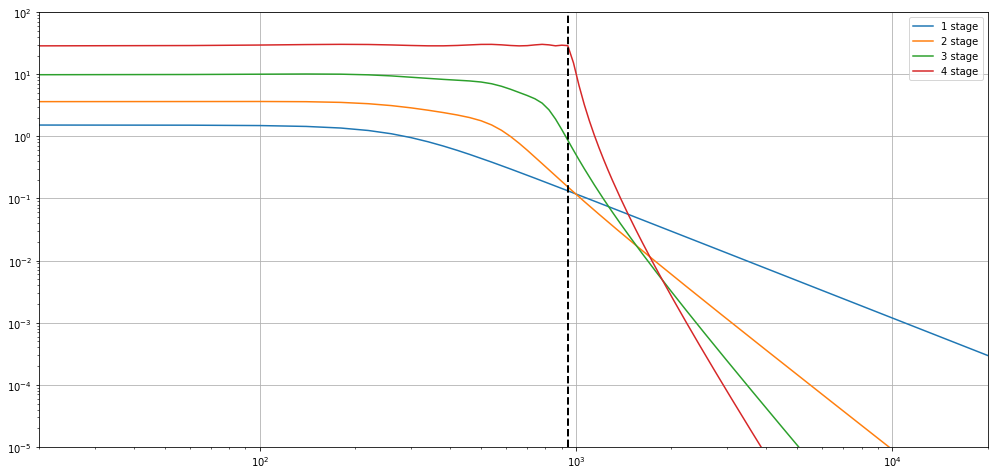

In [23]:
fc = hz2rad(150)
n = 4
print("{}hz = {:.2f}rad/s".format(rad2hz(fc), fc))
# axs, fig = plotBode(freqs[:len(freqs)//2], H_w[:len(freqs)//2], fc)
print('Chebyshev filters by stage number')

f = np.linspace(20,20000,500)
H1 =  [np.abs(H_ChebyshevLow(f1,fc,1)) for f1 in f]
H2 =  [np.abs(H_ChebyshevLow(f1,fc,2)) for f1 in f]
H3 =  [np.abs(H_ChebyshevLow(f1,fc,3)) for f1 in f]
H4 =  [np.abs(H_ChebyshevLow(f1,fc,4)) for f1 in f]

plt.plot(f, H1, label = str(1)+' stage')
plt.plot(f, H2, label = str(2)+' stage')
plt.plot(f, H3, label = str(3)+' stage')
plt.plot(f, H4, label = str(4)+' stage')
plt.axvline(x = fc, ls = '--', c='black', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlim(20, 20000)
plt.ylim(10**(-5),100)
plt.legend()
plt.grid()
plt.gcf().set_size_inches(17,8)

(0.0, 0.004244131815783876)

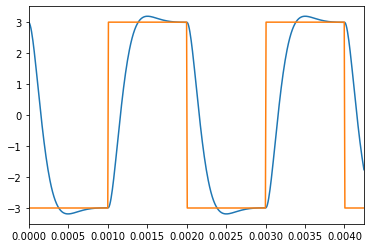

In [24]:
fft_x = np.fft.fft(x)
H = [H_ChebyshevLow(freq,5000, 1) for freq in freqs]
fft_y = fft_x* H
y = np.fft.ifft(fft_y)
plt.plot(t,(1/np.abs(H[2]))*np.real(y))
plt.plot(t,x)
plt.xlim(0,4/fc)


## Filtering the signal by changing its fourier components

The signal has a frequency of 500Hz and all frequencies above 2000Hz will be removed


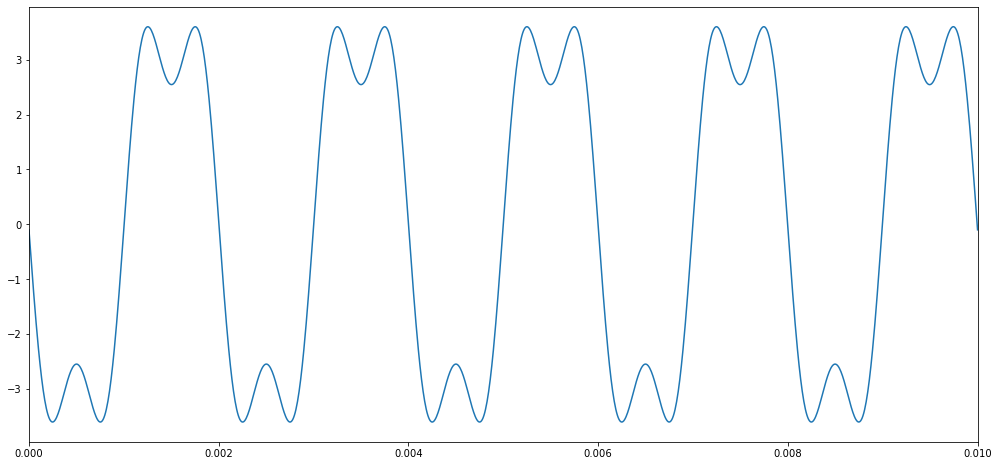

In [25]:

thisCuttoff = (2000)
print('The signal has a frequency of {}Hz and all frequencies above {}Hz will be removed'.format(F,thisCuttoff))
fft_x = np.fft.fft(x)
for i in range(len(freqs)):
    if (np.abs(freqs[i]) > thisCuttoff):
        fft_x[i] = 0

newX = np.fft.ifft(fft_x)
fig = plt.gcf()
plt.plot(t,np.real(newX))
plt.xlim(0,5/F)
fig.set_size_inches(17,8)

# Aliasing analysis

In [60]:
def get_square_from_sample_rate(sampleRate, t0, tf, Fsignal):
    dt = 1/sampleRate
    size = (tf-t0)//dt + 1
    t = np.linspace(t0,tf,int(size))
    signal = [SawWave(i,Fsignal) for i in t]
    fft = np.fft.fft(signal)
    omegas = np.fft.fftfreq(int(size),dt)
    return t,signal, np.abs(fft[:len(omegas)//2]), omegas[:len(omegas)//2]
    

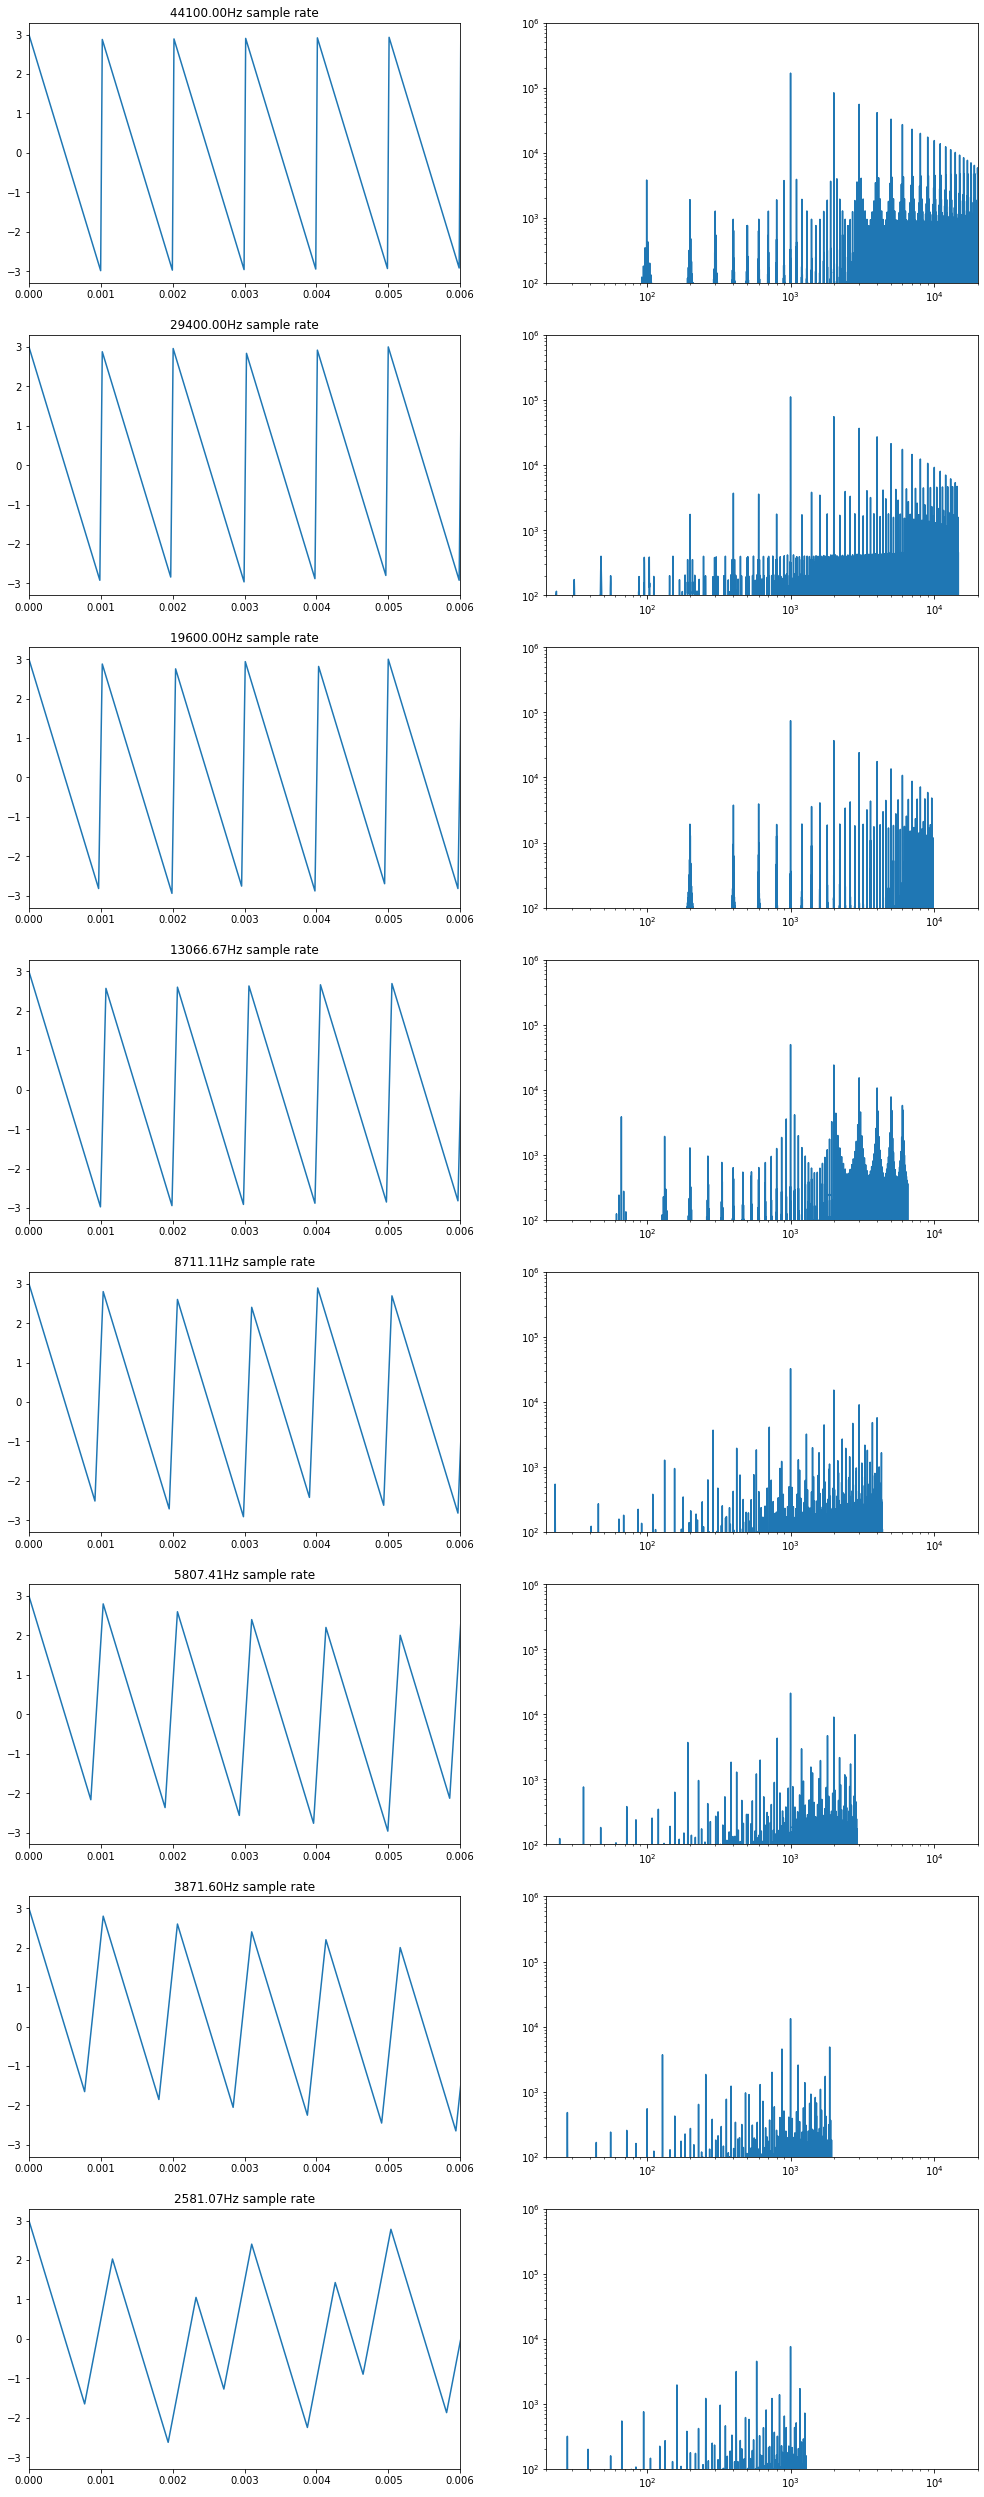

In [79]:
t0 = 0
tf = 4
fs = 44.1*10**3  #sample rate

Fsignal = 1000 # hz

fig, axs = plt.subplots(8,2)

for i in range(8):
    
    t2, x2 , fft, omegas = get_square_from_sample_rate(fs, t0, tf, Fsignal)
    axs[i,0].plot(t2,x2)
    axs[i,0].set_xlim(0,6/Fsignal)
    axs[i,0].set_title('{:.2f}Hz sample rate'.format(fs))
    axs[i,1].plot(omegas,fft)
    axs[i,1].set_yscale('log')
    axs[i,1].set_xscale('log')
    axs[i,1].set_xlim(20,20000)
    axs[i,1].set_ylim(10**2,10**6)
    fs = fs/1.5
    
    
fig.set_size_inches(17,45)